In [2]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fkggnfqa
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-fkggnfqa
  Resolved https://github.com/tensorflow/docs to commit 8f431e2b96ebbebd325a7162a00c40653af799e5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=3e3db746fe434893bc710307afea9e3c17efe056b00d0d2e01f0fee7a4147984
  Stored in directory: /tmp/pip-ephem-wheel-cache-106cv_n6/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [3]:
import tensorflow as tf

from tensorflow.keras import layers, regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
# from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import os
import pathlib

In [5]:
logdir = os.path.join(tempfile.mkdtemp(),'tensorboard_logs')
shutil.rmtree(logdir, ignore_errors=True)

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 46s 0us/step


In [7]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type='GZIP')

In [8]:
def pack_row(*row):
    label = row[0]
    features =tf.stack(row[1:],1)
    return features, label

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


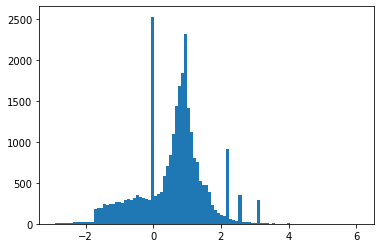

In [10]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
n_val = int(1e3)
n_train = int(1e4)
buffer_size = int(1e4)
batch_size = 500
steps_per_epoch = n_train//batch_size

In [12]:
val_ds = packed_ds.take(n_val).cache()
train_ds = packed_ds.skip(n_val).take(n_train).cache()

In [13]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [14]:
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.shuffle(buffer_size).repeat().batch(batch_size)


In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = steps_per_epoch*1000,
    decay_rate=1,
    staircase = False
)
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

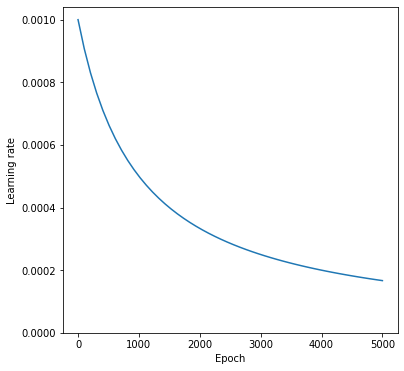

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(6,6))
plt.plot(step/steps_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

In [17]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir+'/'+name),
    ]

In [21]:
def compile_and_fit(model, name, optimizer=None, max_epochs=300):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics=[tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                      'accuracy'])
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = steps_per_epoch,
        epochs = max_epochs,
        validation_data = val_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    return history

## Tiny model

In [23]:
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

In [24]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                464       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4672,  binary_crossentropy:0.8520,  loss:0.8520,  val_accuracy:0.4480,  val_binary_crossentropy:0.8219,  val_loss:0.8219,  
....................................................................................................
Epoch: 100, accuracy:0.5992,  binary_crossentropy:0.6273,  loss:0.6273,  val_accuracy:0.5720,  val_binary_crossentropy:0.6322,  val_loss:0.6322,  
..........................................................

(0.5, 0.7)

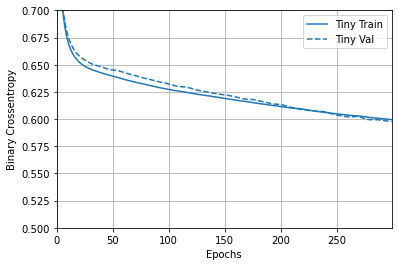

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

## Small model

In [26]:
small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation ='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(6, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [27]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                464       
                                                                 
 dense_6 (Dense)             (None, 6)                 102       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 573
Trainable params: 573
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5036,  binary_crossentropy:0.7097,  loss:0.7097,  val_accuracy:0.4580,  val_binary_crossentropy:0.7063,  val_loss:0.7063,  
....................................................................................................
Epoch: 100, accuracy:0.6369,  binary_crossentropy:0.6079,  loss:0.6079,  

## Medium model

In [28]:
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation ='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [29]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1856      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4848,  binary_crossentropy:0.7016,  loss:0.7016,  val_accuracy:0.4700,  val_binary_crossentropy:0.6878,  val_loss:0.6878,  
....................................